<a href="https://colab.research.google.com/github/nsp8/Machine-Learning-Resources/blob/colab-ml-practice/regression_flood_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from google.colab import drive


#### Horizontal Chart for values associated with text labels

In [140]:
class Charts:
    def __init__(self, data, width=18, height=9, font_family="Sans Serif"):
        self.fig, self.ax = plt.subplots(figsize=(width, height))
        self.data = data
        self.y_pos = [i * 0.9 for i in range(len(data))]
        self.ax.barh(
            self.y_pos,
            self.data.values(),
            height=0.55,
            align="edge",
            color="blue",
        )
        self.font_family = font_family

    @property
    def max_data_value(self):
        return max(self.data.values())

    @property
    def min_data_value(self):
        return min(self.data.values())

    @property
    def axis_period(self):
        return int(self.max_data_value) // 10 or 1

    def set_axes(self):
        from math import ceil
        data_size = len(self.data)
        num_ticks = ceil(self.max_data_value)
        self.ax.xaxis.set_ticks([i * self.axis_period for i in range(num_ticks)])
        self.ax.xaxis.set_ticklabels(
            [i * self.axis_period for i in range(0, num_ticks)],
            size=16,
            fontfamily=self.font_family,
            fontweight=100,
        )
        self.ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)
        self.ax.set_axisbelow(True)
        self.ax.grid(axis="x", color="#8C92AC", lw=1.2)
        self.ax.spines["left"].set_visible(False)
        self.ax.spines["right"].set_visible(False)
        self.ax.spines["top"].set_visible(False)
        self.ax.spines["bottom"].set_visible(False)
        self.ax.spines["left"].set_lw(1.5)
        self.ax.spines["left"].set_capstyle("butt")
        self.ax.yaxis.set_visible(False)
        return self

    def add_bar_text(self, label_object: dict):
        self.ax.text(
            x=label_object["x_pos"],
            y=label_object["y_pos"],
            s=label_object["text"],
            c=label_object["color"],
            fontfamily=self.font_family,
            fontsize=12,
            va="center",
            path_effects=label_object["path_effects"],
        )

    def add_labels(self, padding: float = 0.3):
        for label, value, y_pos in zip(
            self.data.keys(), self.data.values(), self.y_pos
        ):
            value_x_pos = int(self.min_data_value) + padding
            metric_label = dict(
                x_pos=value_x_pos,
                y_pos=(y_pos + 0.25),
                text=label,
                color="white",
                path_effects=[withStroke(linewidth=6, foreground="green")]
            )
            value_label = dict(
                x_pos=value_x_pos + (padding * 1.2),
                y_pos=(y_pos + 0.25),
                text=f"{value}",
                color="green",
                path_effects=[]
            )
            if value < 0:
                metric_label["x_pos"] = self.min_data_value - (padding * 0.5)
                metric_label["path_effects"] = [withStroke(linewidth=6, foreground="red")]
                metric_label["color"] = "white"
                value_label["color"] = "red"
            self.add_bar_text(metric_label)
            self.add_bar_text(value_label)

        return self

    def add_title(self, title, pos=0.5):
        self.fig.text(
            pos, 0.925, title, fontsize=16, fontweight="bold", fontfamily=self.font_family
        )
        return self

    def plot(self, title=None):
        self.set_axes().add_labels()
        if title:
            self.add_title(title)
        plt.show()


In [2]:
drive.mount('/gdrive/')

Mounted at /gdrive/


### **Data Loading**

In [110]:
base_folder_path = os.path.join('/gdrive', 'My Drive', 'Projects', 'ML Practice', 'Regression: flood prediction', 'data')
if os.path.exists(base_folder_path):
    print("Loading data ...")
    train_data = pd.read_csv(os.path.join(base_folder_path, "train.csv"))
    test_data = pd.read_csv(os.path.join(base_folder_path, "test.csv"))
    print("Loaded train and test files from Drive")
else:
    raise FileNotFoundError("Could not locate files")

Loading data ...
Loaded train and test files from Drive


## **Data Exploration**

### Basic statistical analyses

In [4]:
train_data.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [6]:
# Null counts
train_data.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [7]:
# Data type information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

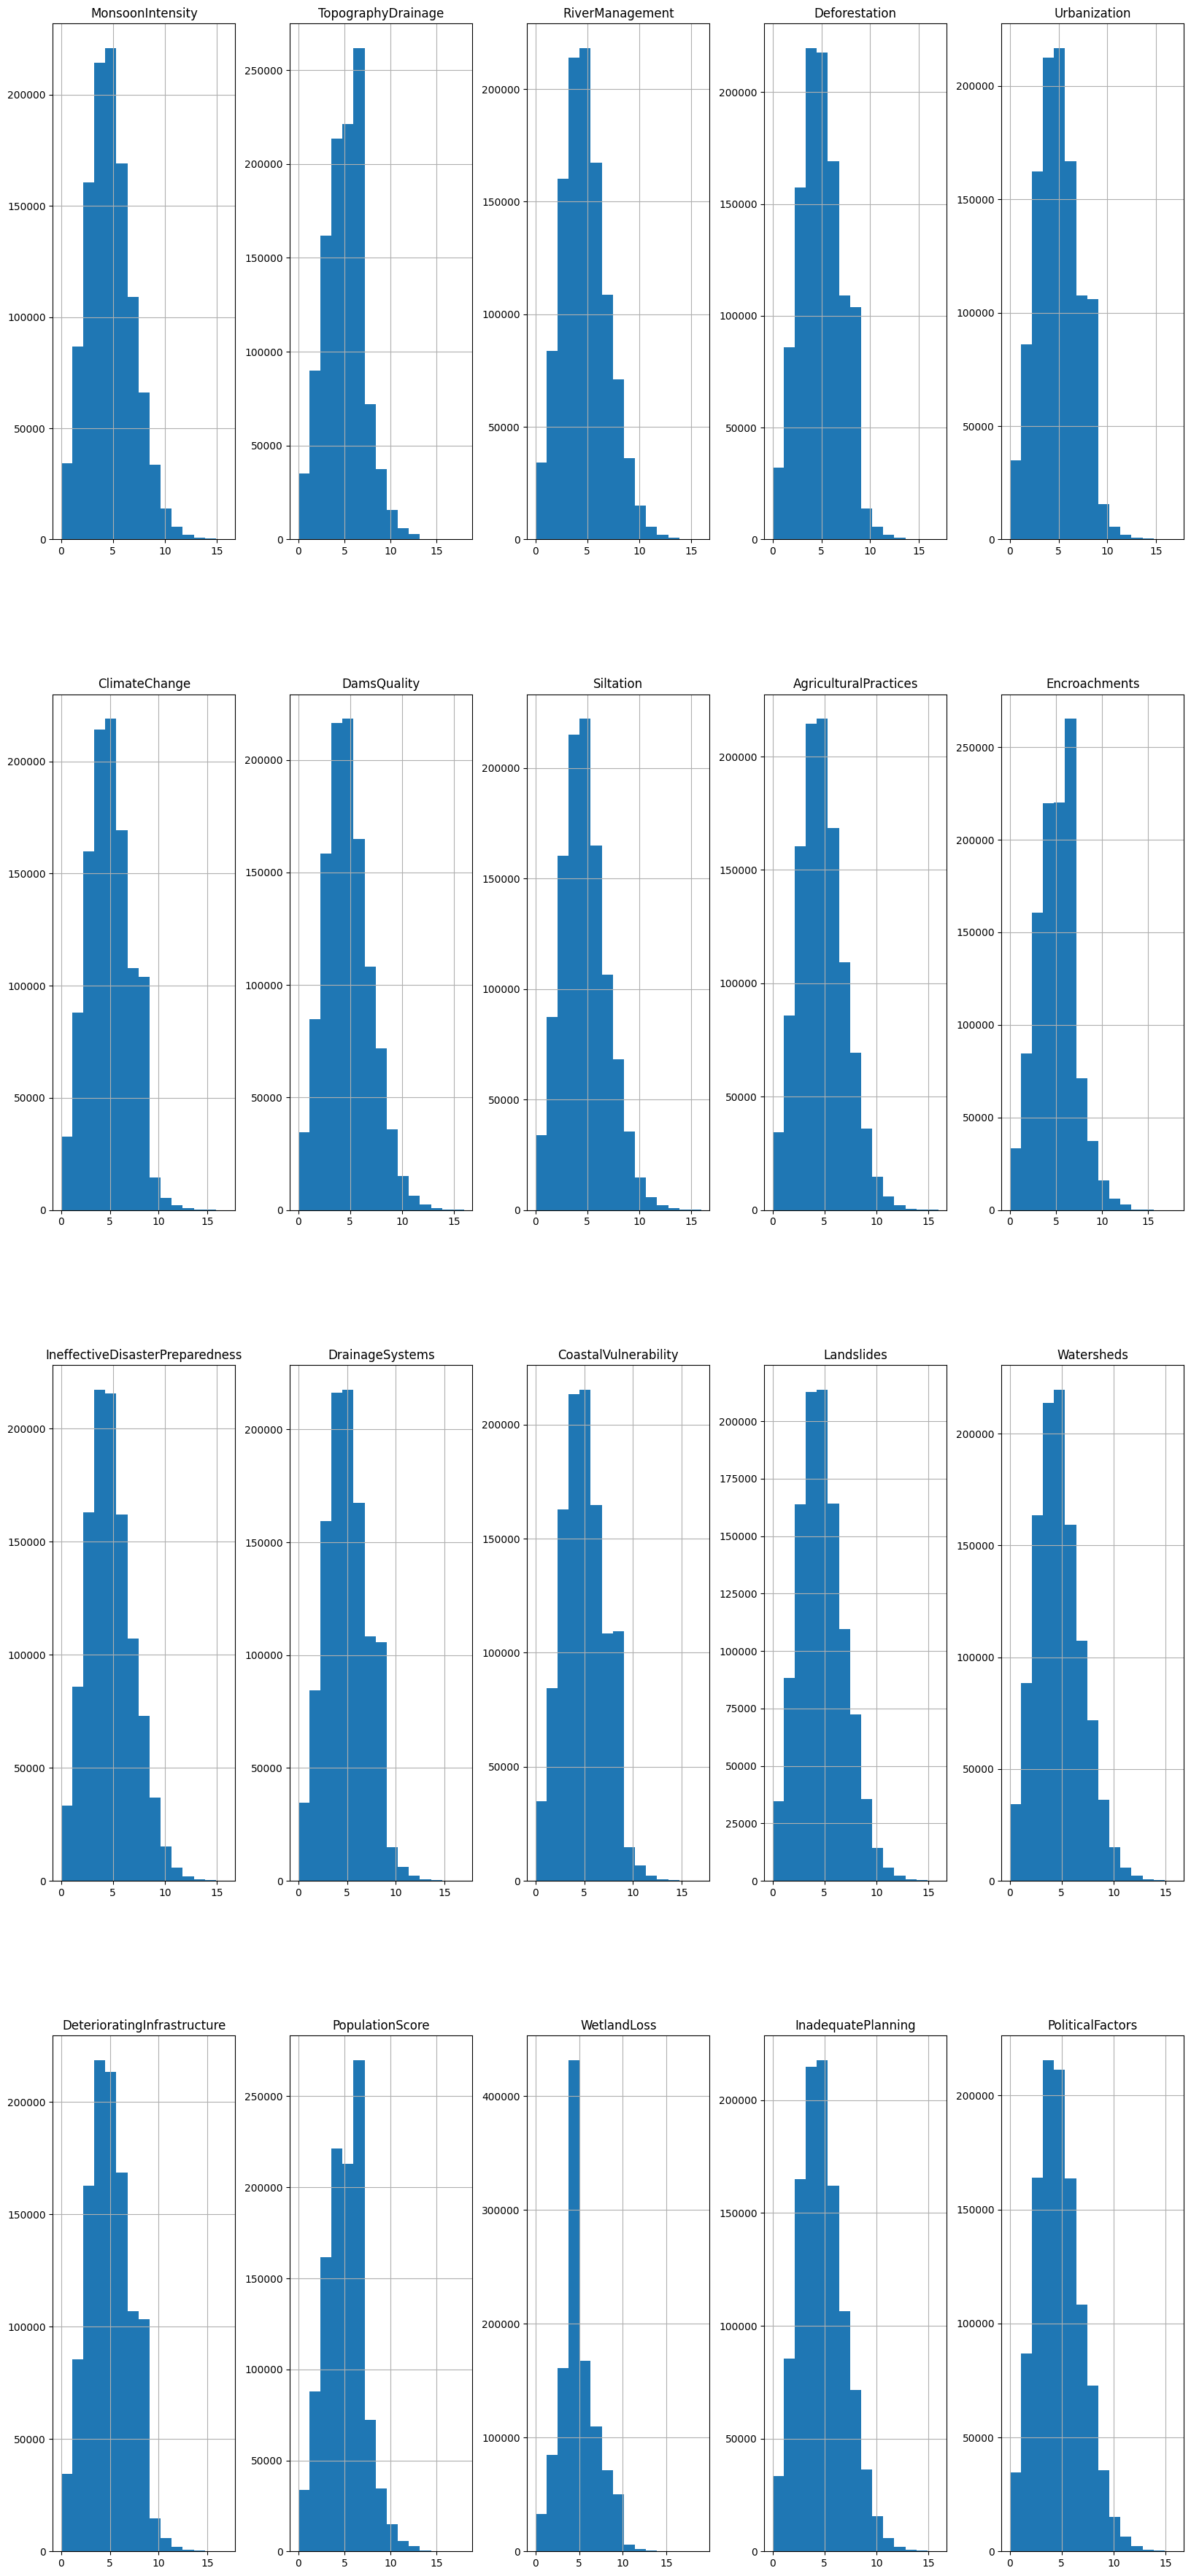

In [8]:
# Layout of data
features_train = train_data.set_index("id")
target_column = "FloodProbability"
label_train = features_train.pop(target_column)
features_train.hist(bins=15, figsize=(20, 45), layout=(4, 5))

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

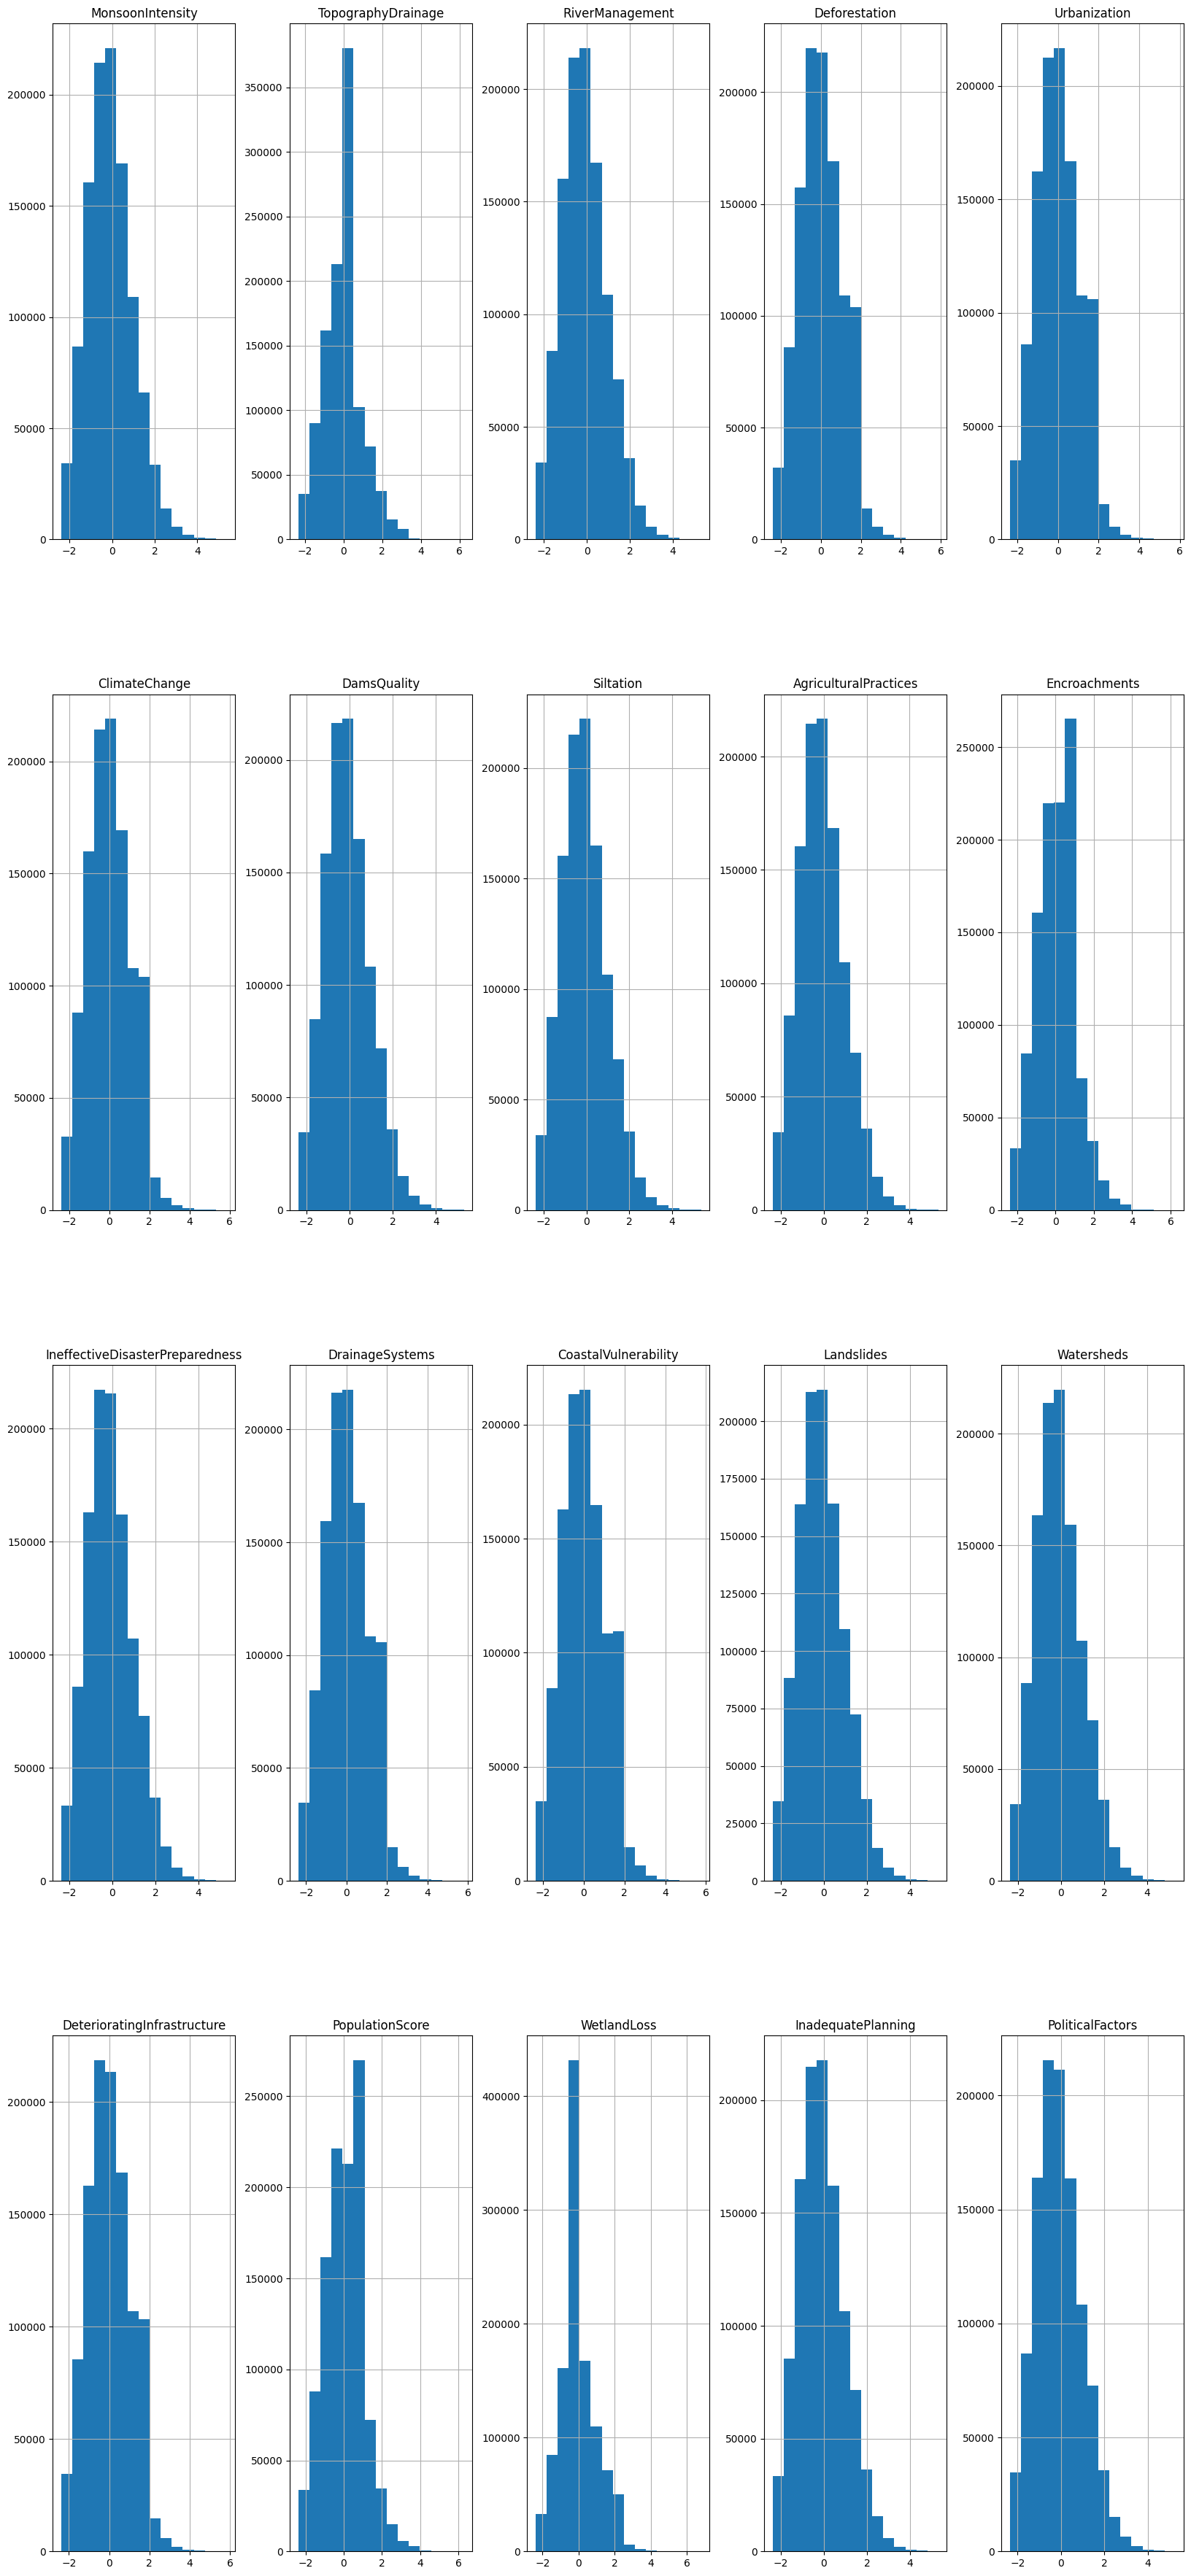

In [9]:
# Standardizing data

def standardize(data):
    standard_scaler = StandardScaler()
    standard_scaler.fit(data)
    return standard_scaler.transform(data)
    # _data = data.copy(deep=True)
    # return (_data - _data.mean(axis=0)) / _data.std(axis=0)


features_train_standardized = pd.DataFrame(standardize(features_train), columns=features_train.columns)
features_train_standardized.hist(bins=15, figsize=(20, 45), layout=(4, 5))
# print(features_train_standardized.shape)

array([[<Axes: title={'center': 'FloodProbability'}>]], dtype=object)

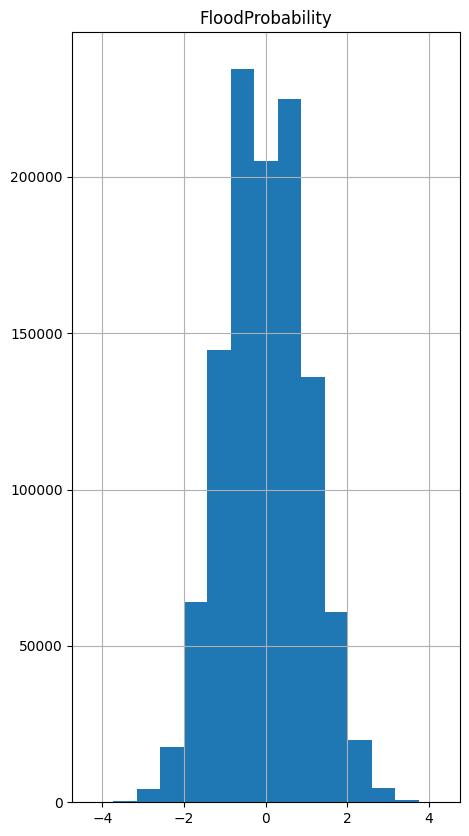

In [10]:
def standardize_labels(label_data):
    mean, std = label_data.mean(), label_data.std()
    return label_data.apply(lambda v: (v - mean) / std)


label_train_standardized = pd.DataFrame(standardize_labels(label_train), columns=[target_column])
label_train_standardized.hist(bins=15, figsize=(5, 10))

#### Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features_train_standardized, label_train_standardized, test_size=0.25)

In [12]:
X_train.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')

#### Correlation matrix of training features

<Axes: >

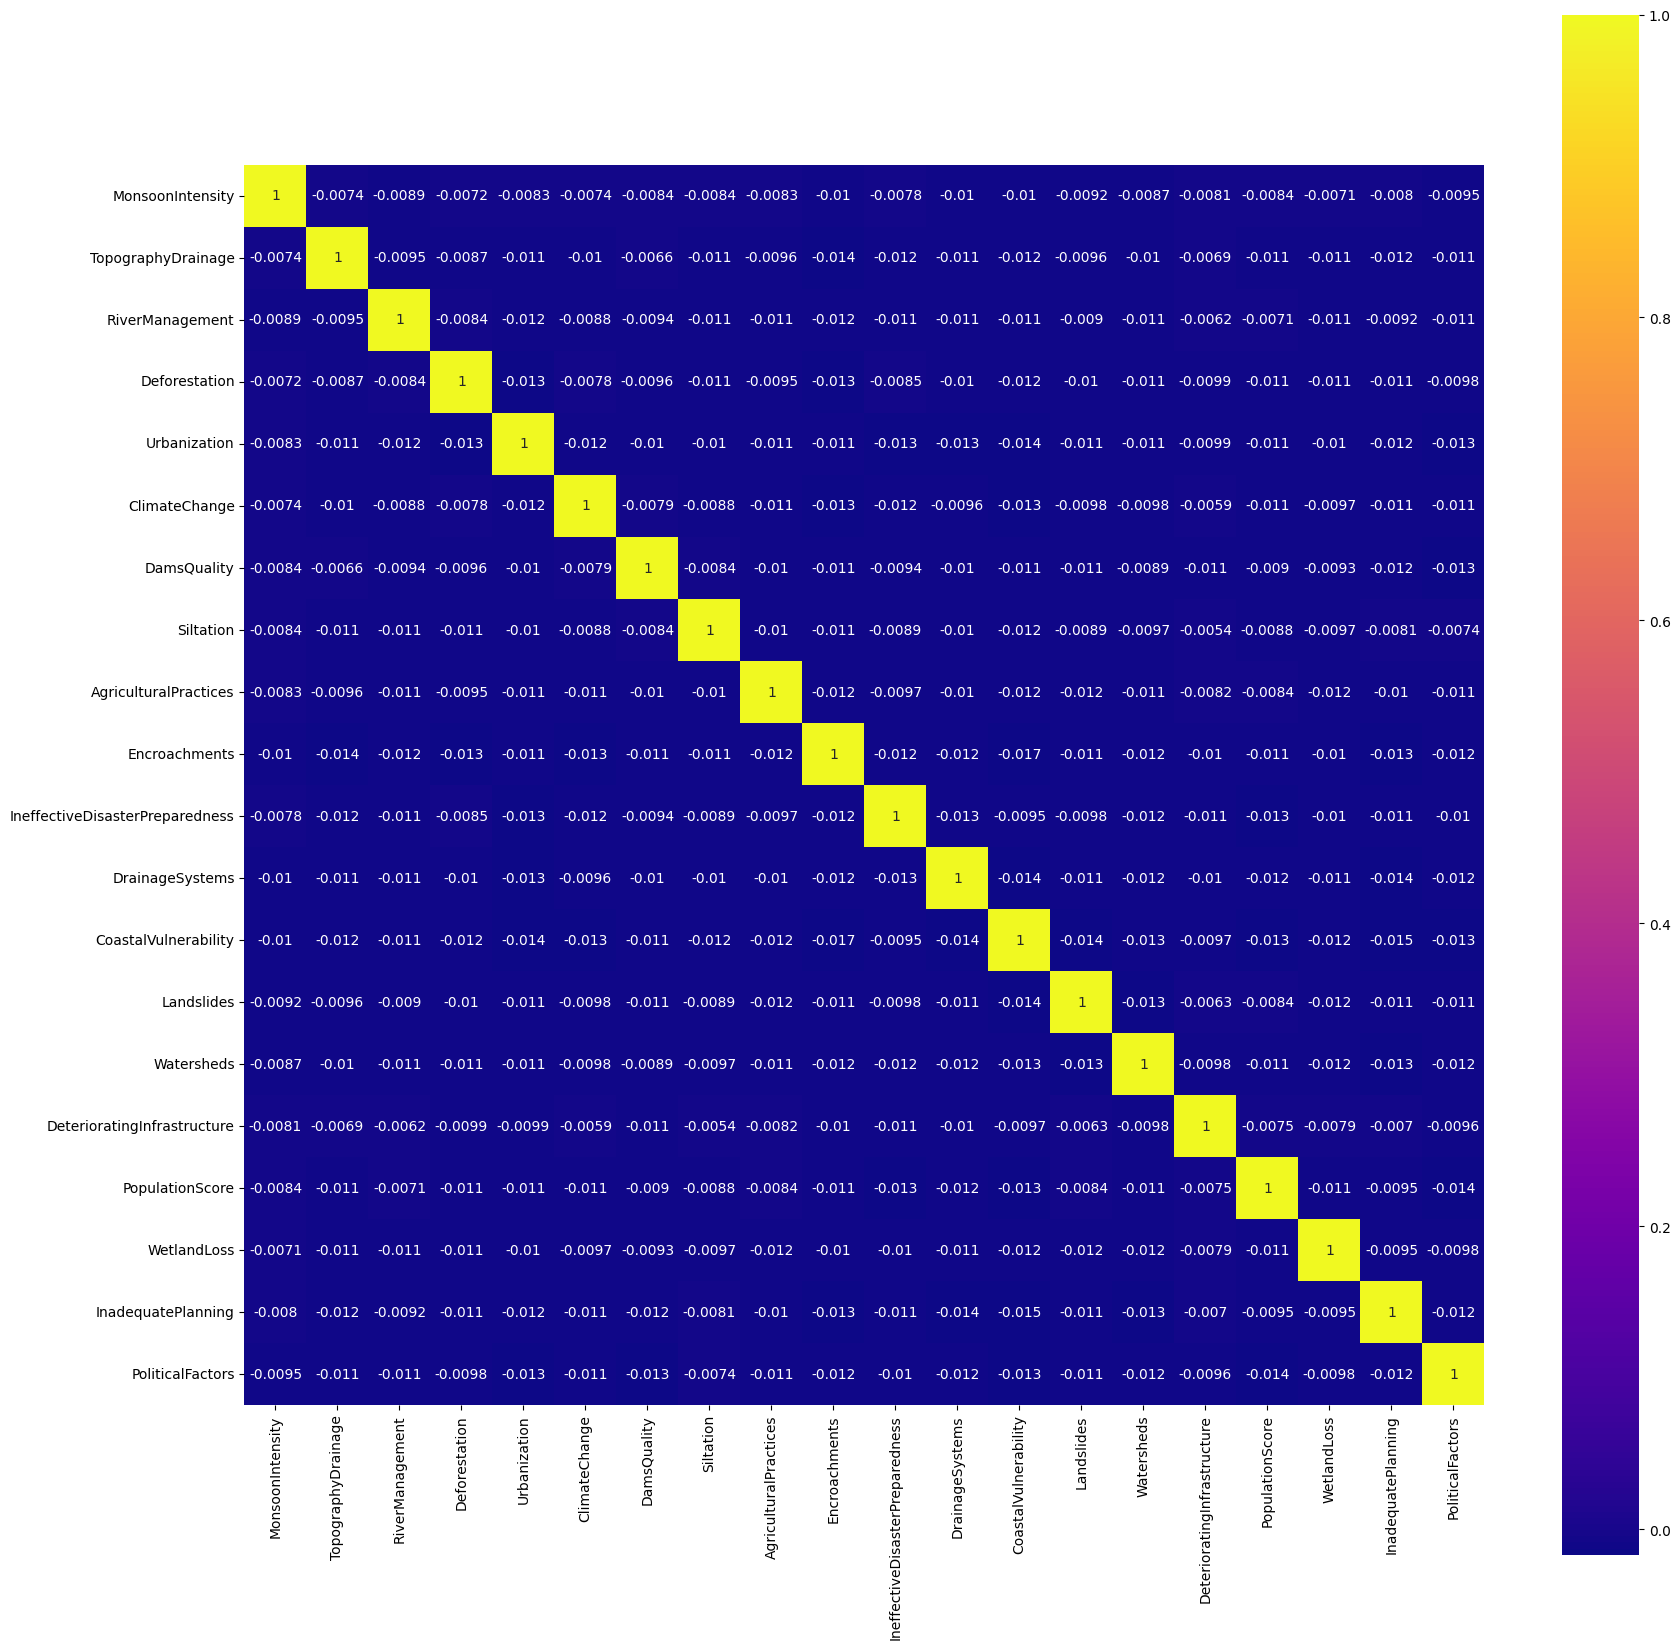

In [21]:
plt.figure(figsize=(20, 20))
sns.heatmap(X_train.corr(), vmax=1, square=True, annot=True, cmap="plasma")

### Feature Analyses


-----------------------------------
PCA Loadings: 
-----------------------------------

                                      PC1       PC2       PC3       PC4  \
MonsoonIntensity                 0.042707  0.023634 -0.007423 -0.125686   
TopographyDrainage               0.240737 -0.014712 -0.278890  0.006710   
RiverManagement                 -0.023624 -0.330084 -0.188167  0.013078   
Deforestation                    0.307970 -0.166491  0.023203  0.167638   
Urbanization                    -0.305024  0.438301 -0.122419 -0.294202   
ClimateChange                    0.098100 -0.181729 -0.132022  0.373302   
DamsQuality                      0.150694  0.219798 -0.327632  0.044024   
Siltation                       -0.156481 -0.065673  0.249764  0.017018   
AgriculturalPractices            0.023851 -0.015778 -0.120438 -0.108448   
Encroachments                   -0.381461  0.421006  0.106277  0.195756   
IneffectiveDisasterPreparedness  0.260567  0.050962  0.305461 -0.245876   
DrainageSys

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



-----------------------------------
Mutual Information Scores: 
-----------------------------------

WetlandLoss                        0.021542
DamsQuality                        0.021283
DeterioratingInfrastructure        0.021096
IneffectiveDisasterPreparedness    0.020721
TopographyDrainage                 0.020405
MonsoonIntensity                   0.020360
Siltation                          0.020105
Deforestation                      0.019837
Landslides                         0.019710
AgriculturalPractices              0.019535
RiverManagement                    0.019507
InadequatePlanning                 0.019307
DrainageSystems                    0.019111
ClimateChange                      0.019097
Watersheds                         0.018655
Urbanization                       0.018629
Encroachments                      0.018364
CoastalVulnerability               0.017967
PopulationScore                    0.017631
PoliticalFactors                   0.017444
Name: Mutual Info 

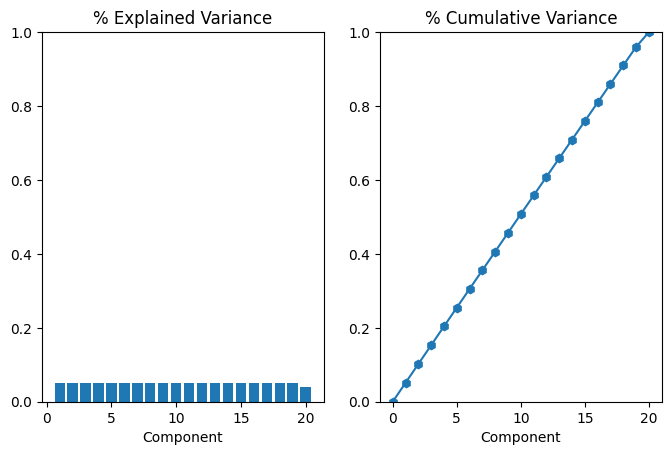

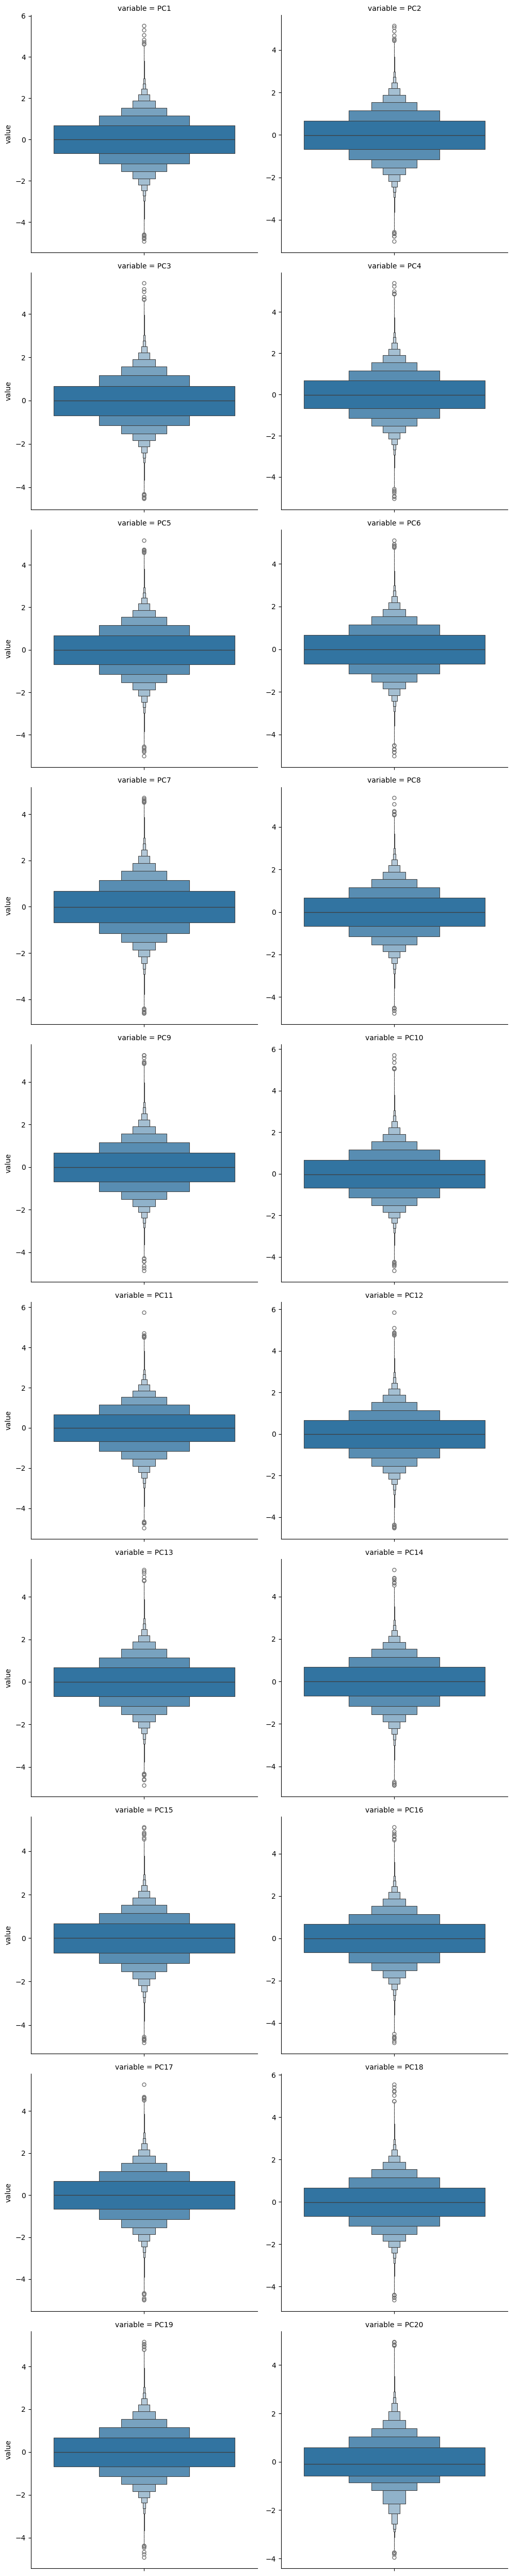

In [111]:
class FeatureAnalyzer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.pca = PCA()
        self.pca.fit_transform(self.X)

    @property
    def X_pca(self):
        x_pca = self.pca.fit_transform(self.X)
        return pd.DataFrame(x_pca, columns=[f"PC{i+1}" for i in range(x_pca.shape[1])])

    @property
    def pca_loadings(self):
        return pd.DataFrame(self.pca.components_.T, columns=self.X_pca.columns, index=self.X.columns)

    def plot_variance(self, width=8, dpi=100):
        fig, axes = plt.subplots(1, 2)
        n = self.pca.n_components_
        print(f"\n{'-' * 35}\nPCA Loadings \n{'-' * 35}\n")
        print(self.pca_loadings)
        grid = np.arange(1, n+1)
        explained_variance = self.pca.explained_variance_ratio_
        axes[0].bar(grid, explained_variance)
        axes[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
        cumulative_variance = np.cumsum(explained_variance)
        axes[1].plot(np.r_[0, grid], np.r_[0, cumulative_variance], marker="h")
        axes[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
        fig.set(figwidth=width, dpi=dpi)
        return axes

    def make_mi_scores(self, discrete_features: bool = False):
        mi_regression = mutual_info_regression(self.X, self.y, discrete_features=discrete_features)
        return pd.Series(mi_regression, name="Mutual Info Scores", index=self.X.columns).sort_values(ascending=False)

    def check_outliers(self):
        sns.catplot(
            y="value",
            col="variable",
            data=self.X_pca.melt(),
            kind="boxen",
            sharey=False,
            col_wrap=2
        )


def show_feature_analysis_artifacts(X, y):
    feature_analyzer = FeatureAnalyzer(X, y)
    feature_analyzer.plot_variance()
    mi_scores = feature_analyzer.make_mi_scores()
    feature_analyzer.check_outliers()
    print(f"\n{'-' * 35}\nMutual Information Scores \n{'-' * 35}\n")
    print(mi_scores)
    return feature_analyzer


feature_analyzer_object = show_feature_analysis_artifacts(X_train, y_train)

In [117]:
feature_analyzer_object.pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
MonsoonIntensity,0.042707,0.023634,-0.007423,-0.125686,0.096102,0.343595,0.057817,-0.052057,-0.073462,0.008786,-0.057286,0.069606,0.397358,-0.400198,0.159768,0.242620,-0.568057,-0.213445,0.174904,0.183132
TopographyDrainage,0.240737,-0.014712,-0.278890,0.006710,0.224881,0.041817,-0.299453,-0.258659,0.176260,-0.061128,-0.499622,0.244249,-0.199763,-0.076879,0.071348,0.075086,-0.047319,0.304548,-0.333971,0.218985
RiverManagement,-0.023624,-0.330084,-0.188167,0.013078,-0.225728,-0.040382,-0.096047,-0.060246,-0.317114,-0.296634,0.011240,-0.276526,-0.237548,0.187112,-0.391347,0.206174,-0.295096,-0.258797,-0.193988,0.213390
Deforestation,0.307970,-0.166491,0.023203,0.167638,-0.122657,0.405605,0.072453,-0.306623,-0.083452,-0.052882,0.159373,-0.148056,-0.004969,0.095012,0.364741,0.261492,0.489215,-0.106608,0.066792,0.217398
Urbanization,-0.305024,0.438301,-0.122419,-0.294202,0.306944,0.192776,-0.314404,-0.155822,0.156517,-0.095103,0.405773,-0.244313,-0.079774,0.125635,-0.092437,0.063140,0.038219,0.074285,0.038074,0.240444
ClimateChange,0.098100,-0.181729,-0.132022,0.373302,0.317078,0.141213,0.042662,0.224419,-0.235616,0.077705,0.395701,0.188790,0.248354,0.239093,-0.026562,-0.236407,-0.152332,0.291495,-0.211791,0.213680
DamsQuality,0.150694,0.219798,-0.327632,0.044024,0.018275,0.022206,-0.018968,0.072125,-0.161848,0.451709,-0.307273,-0.096889,-0.099565,0.365631,0.008414,-0.214394,-0.059086,-0.227848,0.436724,0.208572
Siltation,-0.156481,-0.065673,0.249764,0.017018,0.314239,-0.300426,0.170372,0.053914,0.100198,0.469203,-0.045540,-0.157136,-0.019769,0.133940,0.152966,0.412719,-0.016253,-0.207689,-0.366127,0.202785
AgriculturalPractices,0.023851,-0.015778,-0.120438,-0.108448,-0.181180,0.066197,0.342575,-0.117457,0.579089,-0.081329,0.056791,0.344909,0.208047,0.278158,-0.249427,-0.108543,0.020075,-0.289159,-0.113621,0.220977
Encroachments,-0.381461,0.421006,0.106277,0.195756,-0.394461,-0.030699,0.046931,0.029749,-0.272191,-0.138414,-0.055969,0.396776,-0.118529,0.135918,0.290770,0.117694,-0.068259,0.049793,-0.107407,0.254147


#### Visualize principal components

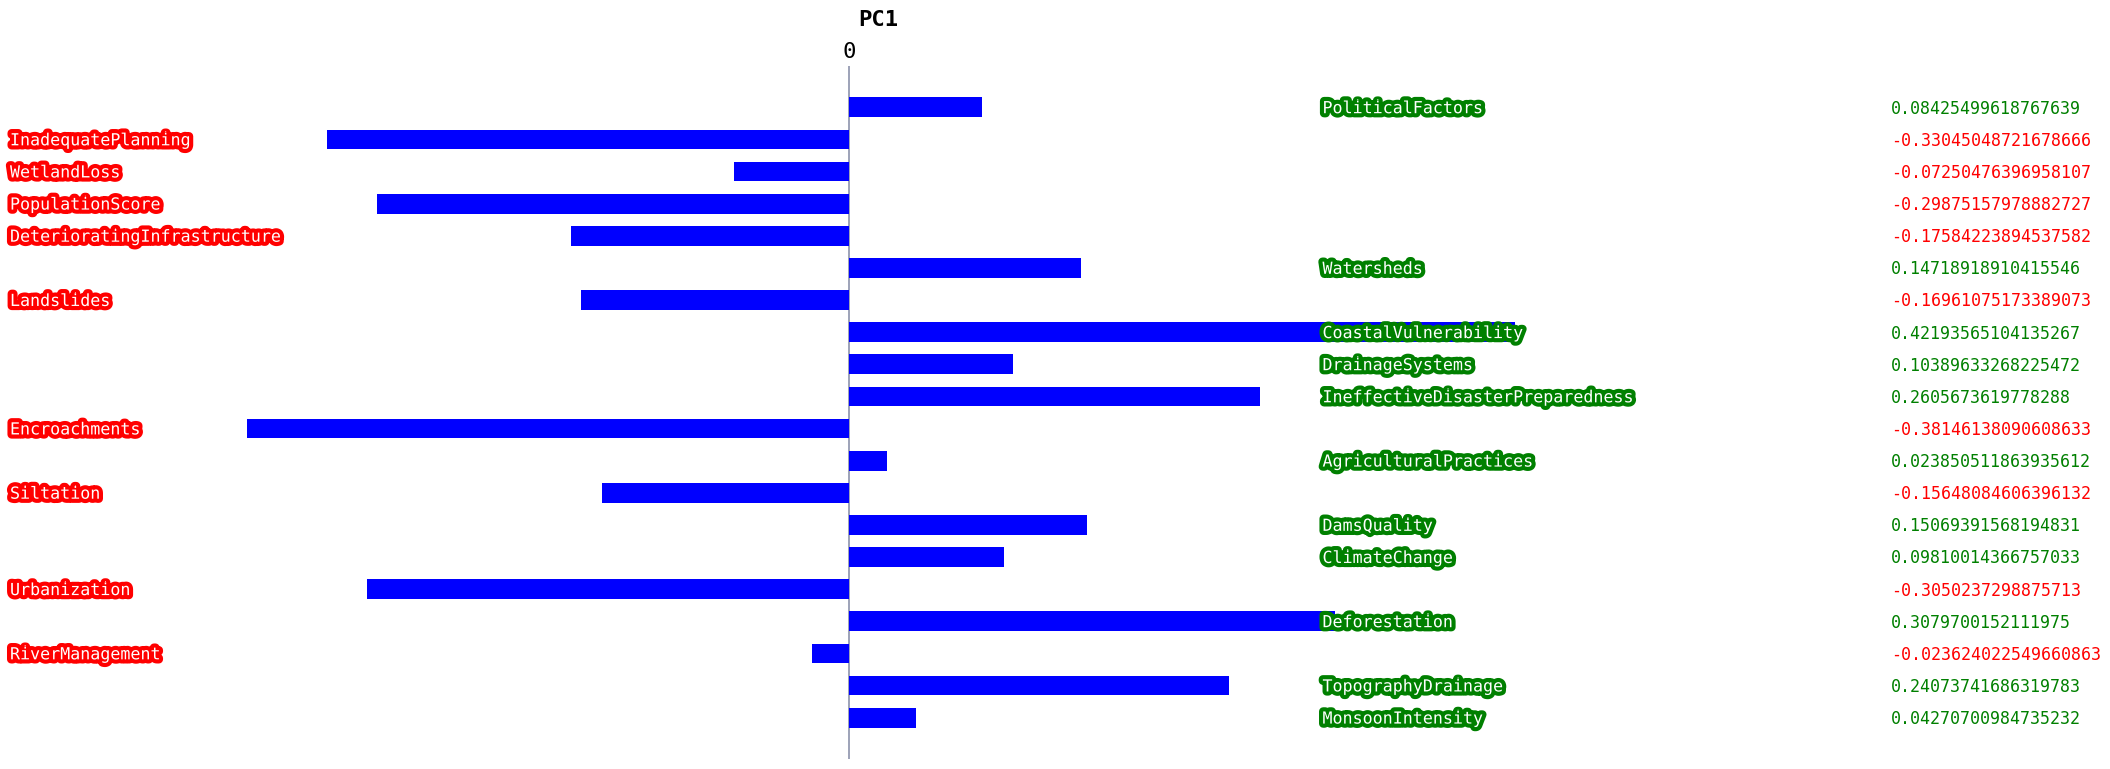

In [144]:
def plot_principal_component(feature_analyzer_object, level=1):
    if level < 1:
        raise ValueError("PC level can't be less than 1")
    _loadings = feature_analyzer_object.pca_loadings
    _column = _loadings.columns[level - 1]
    pc_dataframe = _loadings.loc[:, _column].reset_index().to_dict(orient="records")
    feature_to_pc1 = {_entry["index"]: float(_entry[_column]) for _entry in pc_dataframe}
    chart = Charts(data=feature_to_pc1, font_family="monospace")
    chart.plot(title=_column)

plot_principal_component(feature_analyzer_object, level=1)